In [12]:
!pip install panda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
warnings.simplefilter("ignore")

  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7256 sha256=25f08a28d0fe34ec4141c1a40e430e306cab97f482fff537100fbac702049a64
  Stored in directory: c:\users\rahul\appdata\local\pip\cache\wheels\e6\3d\81\a3665ce657d35359ca337b1db2975dbe5cd281a88b8982f6b6
Successfully built panda


### Extracting Features

In [13]:

features = list()
with open("Features.txt") as f:
    for line in f:
        features.append(line.split()[1])

### Reading Train data

In [15]:

train_df = pd.read_csv("X_train.txt", delim_whitespace = True)

train_df["subject_id"] = pd.read_csv("subject_train.txt", header = None, squeeze = True) #squeeze = True will 
#return data in pandas series format

train_df["activity"] = pd.read_csv("y_train.txt", header = None, squeeze = True)

activity = pd.read_csv("y_train.txt", header = None, squeeze = True)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

train_df["activity_name"] = label_name

train_df.head()

,2.8858451e-001,-2.0294171e-002,-1.3290514e-001,-9.9527860e-001,-9.8311061e-001,-9.1352645e-001,-9.9511208e-001,-9.8318457e-001,-9.2352702e-001,-9.3472378e-001,...,-1.1275434e-001,3.0400372e-002,-4.6476139e-001,-1.8445884e-002,-8.4124676e-001,1.7994061e-001,-5.8626924e-002,subject_id,activity,activity_name
0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
2,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
3,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING
4,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126,1,5,STANDING


### READING Test Data

In [17]:
test_df = pd.read_csv("X_test.txt", delim_whitespace = True, )

test_df["subject_id"] = pd.read_csv("subject_test.txt", header = None, squeeze = True) #squeeze = True will 
#return data in pandas series format

test_df["activity"] = pd.read_csv("y_test.txt", header = None, squeeze = True)

activity = pd.read_csv("y_test.txt", header = None, squeeze = True)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

test_df["activity_name"] = label_name

test_df.head()

,2.5717778e-001,-2.3285230e-002,-1.4653762e-002,-9.3840400e-001,-9.2009078e-001,-6.6768331e-001,-9.5250112e-001,-9.2524867e-001,-6.7430222e-001,-8.9408755e-001,...,6.4624029e-003,1.6291982e-001,-8.2588562e-001,2.7115145e-001,-7.2000927e-001,2.7680104e-001,-5.7978304e-002,subject_id,activity,activity_name
0,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
1,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
2,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
3,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING
4,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,2,5,STANDING


In [18]:
print("Size of Test data = {}".format(test_df.shape))

Size of Test data = (2946, 564)


### Data Cleaning

In [19]:
print("Number of NaN values in train data is "+str(train_df.isnull().sum().sum()))
print("Number of NaN values in test data is "+str(test_df.isnull().sum().sum()))

Number of NaN values in train data is 0
Number of NaN values in test data is 0


In [20]:
print("Number of duplicate values in train data is "+str(sum(train_df.duplicated())))
print("Number of duplicate values in test data is "+str(sum(test_df.duplicated())))

Number of duplicate values in train data is 0
Number of duplicate values in test data is 0


### Checking for imbalance in data

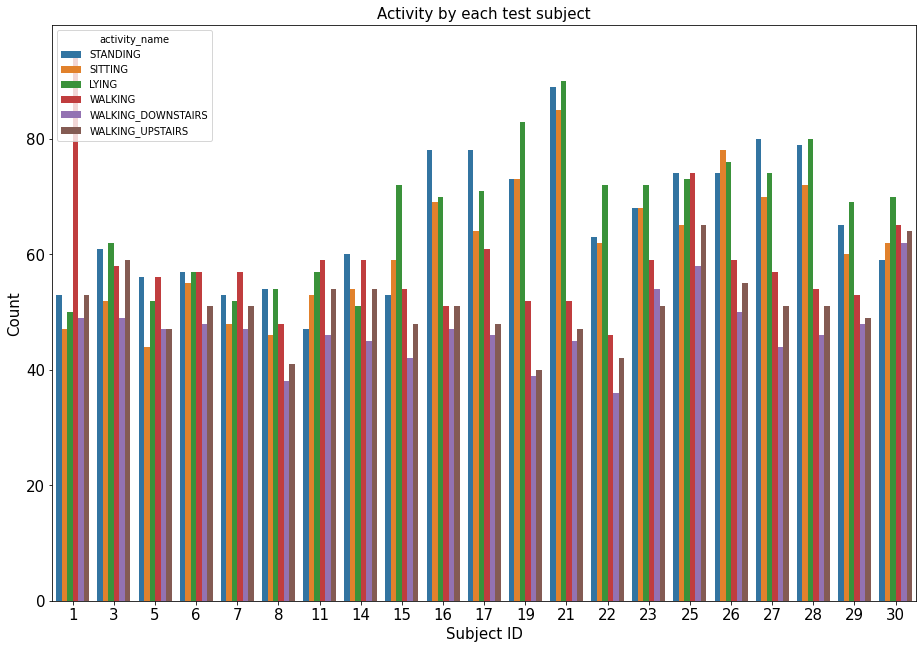

In [21]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Activity by each test subject", fontsize = 15)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "activity_name", data = train_df)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

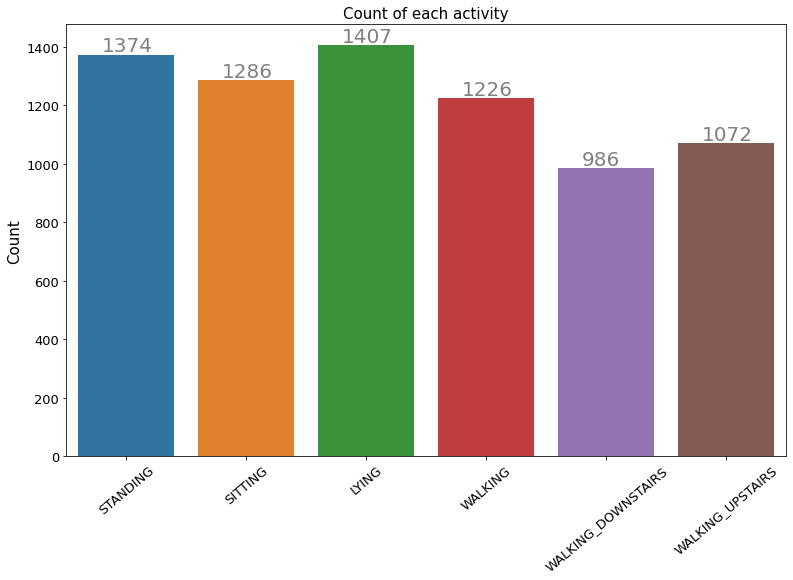

In [22]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each activity", fontsize = 15)
plt.tick_params(labelsize = 10)
sns.countplot(x = "activity_name", data = train_df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+10, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("")
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 13)
plt.xticks(rotation = 40)
plt.show()

# Changing Feature Name

In [24]:
columns = train_df.columns

In [25]:
columns = columns.str.replace("[()]", '') 
columns = columns.str.replace("-", '')
columns = columns.str.replace(",", '')
#here, columns is of type pandas index. By writing "columns.str" we have changed its type to 
#pandas string. Pandas string has method called replace which we have used here.

train_df.columns = columns
test_df.columns = columns

In [26]:
train_df.columns

Index(['2.8858451e001', '2.0294171e002', '1.3290514e001', '9.9527860e001',
       '9.8311061e001', '9.1352645e001', '9.9511208e001', '9.8318457e001',
       '9.2352702e001', '9.3472378e001',
       ...
       '1.1275434e001', '3.0400372e002', '4.6476139e001', '1.8445884e002',
       '8.4124676e001', '1.7994061e001', '5.8626924e002', 'subject_id',
       'activity', 'activity_name'],
      dtype='object', length=564)

In [27]:
train_df.head()

,2.8858451e001,2.0294171e002,1.3290514e001,9.9527860e001,9.8311061e001,9.1352645e001,9.9511208e001,9.8318457e001,9.2352702e001,9.3472378e001,...,1.1275434e001,3.0400372e002,4.6476139e001,1.8445884e002,8.4124676e001,1.7994061e001,5.8626924e002,subject_id,activity,activity_name
0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
2,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
3,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING
4,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126,1,5,STANDING


In [28]:
train_df.to_csv("train_df.csv", index = False)
test_df.to_csv("test_df.csv", index = False)

In [29]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

KeyError: "None of [Index(['tBodyAccMagmean'], dtype='object')] are in the [columns]"

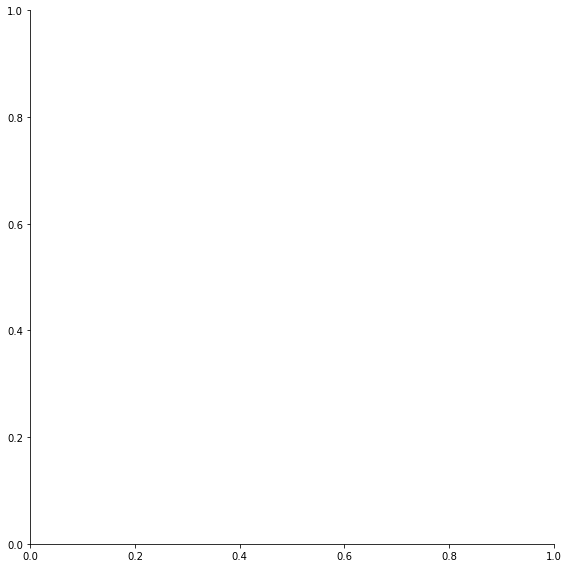

In [30]:
facetgrid = sns.FacetGrid(data = train_df, hue = "activity_name", size = 8)
facetgrid.map(sns.distplot, "tBodyAccMagmean", hist = False).add_legend()
plt.annotate('Static Activities(Sitting, Standing, Lying)', xy=(-0.97, 23), xytext=(-0.7, 27),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 15), size = 15, color = "#232b2b")
plt.annotate('Dynamic Activities(Walking, Walking_Upstairs, Walking_Downstairs)', xy=(0.1, 3), xytext=(0.4, 6),
            arrowprops=dict(facecolor='orange', width = 7, headlength = 13), size = 15, color = "#232b2b")
plt.show()